***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.8)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>24D>16D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_2_8')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 24
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5203 - prediction_coarse_accuracy: 0.4542 - prediction_medium_accuracy: 0.2111 - prediction_fine_accuracy: 0.0062
  • Coarse Accuracy = 45.42% | Val_Accuracy = 54.76% | LossWeight = 0.37 
  • Medium Accuracy = 21.11% | Val_Accuracy = 30.56% | LossWeight = 0.48 
  • Fine   Accuracy = 0.62% | Val_Accuracy = 0.61% | LossWeight = 0.16 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00610, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 65s 73ms/step - loss: 0.5203 - prediction_coarse_accuracy: 0.4542 - prediction_medium_accuracy: 0.2111 - prediction_fine_accuracy: 0.0062 - val_loss: 0.4373 - val_prediction_coarse_accuracy: 0.5476 - val_prediction_medium_accuracy: 0.3056 - val_prediction_fine_accuracy: 0.0061 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3956 - prediction_coarse_accuracy: 0.5792 - 

781/781 [==============================] - 56s 72ms/step - loss: 0.2536 - prediction_coarse_accuracy: 0.8031 - prediction_medium_accuracy: 0.6905 - prediction_fine_accuracy: 0.0681 - val_loss: 0.2294 - val_prediction_coarse_accuracy: 0.7946 - val_prediction_medium_accuracy: 0.6690 - val_prediction_fine_accuracy: 0.0923 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.2378 - prediction_coarse_accuracy: 0.8190 - prediction_medium_accuracy: 0.7189 - prediction_fine_accuracy: 0.1221
  • Coarse Accuracy = 81.90% | Val_Accuracy = 77.93% | LossWeight = 0.28 
  • Medium Accuracy = 71.89% | Val_Accuracy = 65.45% | LossWeight = 0.40 
  • Fine   Accuracy = 12.21% | Val_Accuracy = 13.74% | LossWeight = 0.32 

Epoch 10: val_prediction_fine_accuracy improved from 0.09230 to 0.13740, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 57s 73ms/step - loss: 0.2378 - prediction_coarse_accuracy: 0.8190 -

781/781 [==============================] - 56s 72ms/step - loss: 0.1660 - prediction_coarse_accuracy: 0.8941 - prediction_medium_accuracy: 0.8439 - prediction_fine_accuracy: 0.3120 - val_loss: 0.1830 - val_prediction_coarse_accuracy: 0.8189 - val_prediction_medium_accuracy: 0.7114 - val_prediction_fine_accuracy: 0.2949 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1611 - prediction_coarse_accuracy: 0.9015 - prediction_medium_accuracy: 0.8528 - prediction_fine_accuracy: 0.3311
  • Coarse Accuracy = 90.15% | Val_Accuracy = 80.90% | LossWeight = 0.25 
  • Medium Accuracy = 85.28% | Val_Accuracy = 70.12% | LossWeight = 0.34 
  • Fine   Accuracy = 33.11% | Val_Accuracy = 30.02% | LossWeight = 0.40 

Epoch 19: val_prediction_fine_accuracy improved from 0.29490 to 0.30020, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 57s 72ms/step - loss: 0.1611 - prediction_coarse_accuracy: 0.90

781/781 [==============================] - 56s 72ms/step - loss: 0.1329 - prediction_coarse_accuracy: 0.9306 - prediction_medium_accuracy: 0.9060 - prediction_fine_accuracy: 0.4659 - val_loss: 0.1654 - val_prediction_coarse_accuracy: 0.8344 - val_prediction_medium_accuracy: 0.7360 - val_prediction_fine_accuracy: 0.4140 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1314 - prediction_coarse_accuracy: 0.9331 - prediction_medium_accuracy: 0.9085 - prediction_fine_accuracy: 0.4789
  • Coarse Accuracy = 93.31% | Val_Accuracy = 83.53% | LossWeight = 0.25 
  • Medium Accuracy = 90.85% | Val_Accuracy = 73.57% | LossWeight = 0.30 
  • Fine   Accuracy = 47.89% | Val_Accuracy = 42.51% | LossWeight = 0.45 

Epoch 28: val_prediction_fine_accuracy improved from 0.41400 to 0.42510, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 56s 72ms/step - loss: 0.1314 - prediction_coarse_accuracy: 0.93

781/781 [==============================] - 56s 72ms/step - loss: 0.1202 - prediction_coarse_accuracy: 0.9434 - prediction_medium_accuracy: 0.9242 - prediction_fine_accuracy: 0.5581 - val_loss: 0.1593 - val_prediction_coarse_accuracy: 0.8409 - val_prediction_medium_accuracy: 0.7424 - val_prediction_fine_accuracy: 0.4650 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1174 - prediction_coarse_accuracy: 0.9440 - prediction_medium_accuracy: 0.9282 - prediction_fine_accuracy: 0.5709
  • Coarse Accuracy = 94.40% | Val_Accuracy = 83.90% | LossWeight = 0.25 
  • Medium Accuracy = 92.82% | Val_Accuracy = 74.42% | LossWeight = 0.29 
  • Fine   Accuracy = 57.09% | Val_Accuracy = 46.62% | LossWeight = 0.45 

Epoch 37: val_prediction_fine_accuracy improved from 0.46500 to 0.46620, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 57s 72ms/step - loss: 0.1174 - prediction_coarse_accuracy: 0.94

781/781 [==============================] - 57s 72ms/step - loss: 0.1133 - prediction_coarse_accuracy: 0.9489 - prediction_medium_accuracy: 0.9355 - prediction_fine_accuracy: 0.6133 - val_loss: 0.1555 - val_prediction_coarse_accuracy: 0.8419 - val_prediction_medium_accuracy: 0.7487 - val_prediction_fine_accuracy: 0.5000 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.1126 - prediction_coarse_accuracy: 0.9498 - prediction_medium_accuracy: 0.9357 - prediction_fine_accuracy: 0.6158
  • Coarse Accuracy = 94.98% | Val_Accuracy = 84.09% | LossWeight = 0.25 
  • Medium Accuracy = 93.57% | Val_Accuracy = 74.83% | LossWeight = 0.29 
  • Fine   Accuracy = 61.58% | Val_Accuracy = 50.19% | LossWeight = 0.45 

Epoch 46: val_prediction_fine_accuracy improved from 0.50000 to 0.50190, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 56s 72ms/step - loss: 0.1126 - prediction_coarse_accuracy: 0.94

781/781 [==============================] - 56s 72ms/step - loss: 0.1085 - prediction_coarse_accuracy: 0.9534 - prediction_medium_accuracy: 0.9402 - prediction_fine_accuracy: 0.6468 - val_loss: 0.1541 - val_prediction_coarse_accuracy: 0.8449 - val_prediction_medium_accuracy: 0.7532 - val_prediction_fine_accuracy: 0.5187 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.1086 - prediction_coarse_accuracy: 0.9514 - prediction_medium_accuracy: 0.9384 - prediction_fine_accuracy: 0.6526
  • Coarse Accuracy = 95.14% | Val_Accuracy = 84.06% | LossWeight = 0.26 
  • Medium Accuracy = 93.84% | Val_Accuracy = 75.31% | LossWeight = 0.30 
  • Fine   Accuracy = 65.26% | Val_Accuracy = 51.94% | LossWeight = 0.44 

Epoch 55: val_prediction_fine_accuracy improved from 0.51870 to 0.51940, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 57s 72ms/step - loss: 0.1086 - prediction_coarse_accuracy: 0.95

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.1080 - prediction_coarse_accuracy: 0.9524 - prediction_medium_accuracy: 0.9390 - prediction_fine_accuracy: 0.6701
  • Coarse Accuracy = 95.24% | Val_Accuracy = 84.60% | LossWeight = 0.27 
  • Medium Accuracy = 93.90% | Val_Accuracy = 75.51% | LossWeight = 0.31 
  • Fine   Accuracy = 67.01% | Val_Accuracy = 52.75% | LossWeight = 0.43 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.52950
781/781 [==============================] - 56s 72ms/step - loss: 0.1080 - prediction_coarse_accuracy: 0.9524 - prediction_medium_accuracy: 0.9390 - prediction_fine_accuracy: 0.6701 - val_loss: 0.1519 - val_prediction_coarse_accuracy: 0.8460 - val_prediction_medium_accuracy: 0.7551 - val_prediction_fine_accuracy: 0.5275 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.1075 - prediction_coarse_accuracy: 0.9532 - prediction_medium_accuracy: 0.9412 - prediction_fine_accuracy: 0.

781/781 [==============================] - 58s 74ms/step - loss: 0.1047 - prediction_coarse_accuracy: 0.9536 - prediction_medium_accuracy: 0.9425 - prediction_fine_accuracy: 0.6913 - val_loss: 0.1509 - val_prediction_coarse_accuracy: 0.8473 - val_prediction_medium_accuracy: 0.7586 - val_prediction_fine_accuracy: 0.5370 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.1054 - prediction_coarse_accuracy: 0.9542 - prediction_medium_accuracy: 0.9441 - prediction_fine_accuracy: 0.6932
  • Coarse Accuracy = 95.42% | Val_Accuracy = 84.83% | LossWeight = 0.27 
  • Medium Accuracy = 94.41% | Val_Accuracy = 75.77% | LossWeight = 0.30 
  • Fine   Accuracy = 69.32% | Val_Accuracy = 53.72% | LossWeight = 0.43 

Epoch 83: val_prediction_fine_accuracy improved from 0.53700 to 0.53720, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_2_8\epoch-best.h5
781/781 [==============================] - 58s 74ms/step - loss: 0.1054 - prediction_coarse_accuracy: 0.95

Epoch 92/100
781/781 [==============================] - ETA: 0s - loss: 0.1048 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9437 - prediction_fine_accuracy: 0.6971
  • Coarse Accuracy = 95.55% | Val_Accuracy = 84.79% | LossWeight = 0.27 
  • Medium Accuracy = 94.37% | Val_Accuracy = 75.90% | LossWeight = 0.31 
  • Fine   Accuracy = 69.71% | Val_Accuracy = 53.99% | LossWeight = 0.43 

Epoch 92: val_prediction_fine_accuracy did not improve from 0.54070
781/781 [==============================] - 58s 74ms/step - loss: 0.1048 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9437 - prediction_fine_accuracy: 0.6971 - val_loss: 0.1513 - val_prediction_coarse_accuracy: 0.8479 - val_prediction_medium_accuracy: 0.7590 - val_prediction_fine_accuracy: 0.5399 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.1042 - prediction_coarse_accuracy: 0.9551 - prediction_medium_accuracy: 0.9439 - prediction_fine_accuracy: 0.

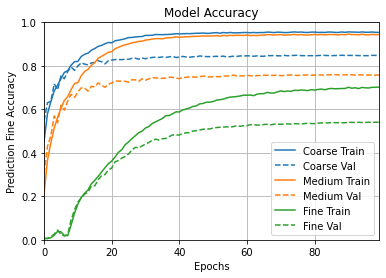

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

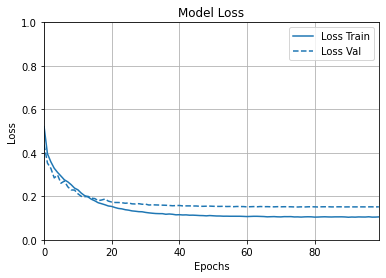

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 19ms/step - loss: 0.2465 - prediction_coarse_loss: 0.1163 - prediction_medium_loss: 0.1861 - prediction_fine_loss: 0.3768 - prediction_coarse_accuracy: 0.8474 - prediction_medium_accuracy: 0.7579 - prediction_fine_accuracy: 0.5404
1. loss ==> 0.24652589857578278
2. prediction_coarse_loss ==> 0.11634455621242523
3. prediction_medium_loss ==> 0.1860772669315338
4. prediction_fine_loss ==> 0.3767662048339844
5. prediction_coarse_accuracy ==> 0.8474000096321106
6. prediction_medium_accuracy ==> 0.7578999996185303
7. prediction_fine_accuracy ==> 0.5404000282287598
313/313 [==============================] - 5s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

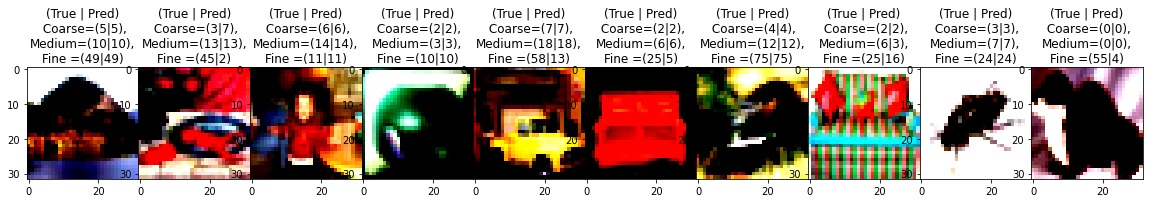

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 675   16   24   35  207   13   12   18]
 [  10 1356   30   31   42   20    4    7]
 [  11   33 1327   24   37   11   15   42]
 [  17   32   35  770  128    2    2   14]
 [  95   22   47  106 2174   12   11   33]
 [  12   26   20    6   30  877    1   28]
 [   7   10   20   14   38    1  406    4]
 [   3    3   30   11   33   29    2  889]]

  • MEDIUM LEVEL 
[[305  19   1   0   4   7   2   6  18   2   4  11  28  14   5  33  32   0
    4   5]
 [ 21 356  10   4   4   8   2   7   4   3   5   8   9   7  10  28   6   0
    3   5]
 [  0   4 441   5  19   2   1  11   1   1   1   1   1   1   0   3   2   3
    1   2]
 [  0   1   7 396  10  44   6   3   2   2   0   2   1   6   5   2   0   0
    2  11]
 [  1   4  23   9 411   8   2   9   6   1   2   0   0   9   3   7   2   2
    1   0]
 [  4   6   3  28   3 372  27   3   1   3   2   2   1   7   8   5   3   2
    8  12]
 [  1   2   1  12   2  20 422   4   0   5   2   0   2   4   5   3   1   2
    6   6]


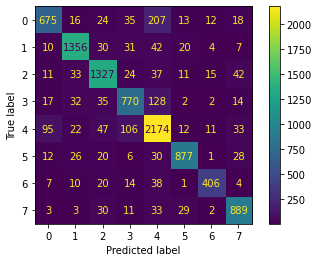

              precision    recall  f1-score   support

           0    0.81325   0.67500   0.73770      1000
           1    0.90521   0.90400   0.90460      1500
           2    0.86562   0.88467   0.87504      1500
           3    0.77232   0.77000   0.77116      1000
           4    0.80848   0.86960   0.83793      2500
           5    0.90881   0.87700   0.89262      1000
           6    0.89625   0.81200   0.85205       500
           7    0.85894   0.88900   0.87371      1000

    accuracy                        0.84740     10000
   macro avg    0.85361   0.83516   0.84310     10000
weighted avg    0.84789   0.84740   0.84655     10000


  • MEDIUM LEVEL 


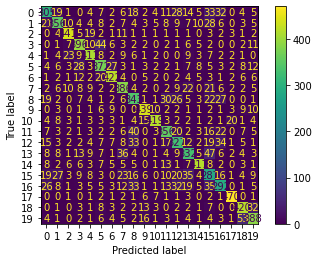

              precision    recall  f1-score   support

           0    0.68694   0.61000   0.64619       500
           1    0.76724   0.71200   0.73859       500
           2    0.85631   0.88200   0.86897       500
           3    0.77647   0.79200   0.78416       500
           4    0.81386   0.82200   0.81791       500
           5    0.71538   0.74400   0.72941       500
           6    0.83730   0.84400   0.84064       500
           7    0.72150   0.77200   0.74589       500
           8    0.66089   0.68600   0.67321       500
           9    0.85078   0.87800   0.86417       500
          10    0.90302   0.83800   0.86929       500
          11    0.74477   0.71200   0.72802       500
          12    0.66194   0.65400   0.65795       500
          13    0.67206   0.66400   0.66801       500
          14    0.87056   0.83400   0.85189       500
          15    0.51899   0.57400   0.54511       500
          16    0.63895   0.58400   0.61024       500
          17    0.92338   0

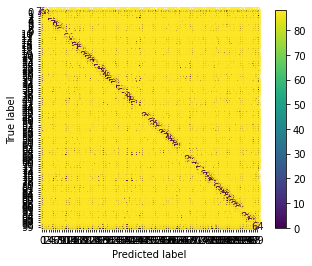

              precision    recall  f1-score   support

           0    0.88235   0.75000   0.81081       100
           1    0.77500   0.62000   0.68889       100
           2    0.26257   0.47000   0.33692       100
           3    0.41176   0.28000   0.33333       100
           4    0.31858   0.36000   0.33803       100
           5    0.42063   0.53000   0.46903       100
           6    0.66667   0.70000   0.68293       100
           7    0.63333   0.57000   0.60000       100
           8    0.78824   0.67000   0.72432       100
           9    0.85135   0.63000   0.72414       100
          10    0.25385   0.33000   0.28696       100
          11    0.33333   0.14000   0.19718       100
          12    0.53226   0.66000   0.58929       100
          13    0.37168   0.42000   0.39437       100
          14    0.35766   0.49000   0.41350       100
          15    0.55405   0.41000   0.47126       100
          16    0.58000   0.58000   0.58000       100
          17    0.86747   0

In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7144966666666667 
Hierarchical Recall = 0.7273333333333333 
Hierarchical F1-Score = 0.7195468253968255 
Consistency =  0.915 
Exact Match =  0.5274


# Training Again

In [22]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1392 - prediction_coarse_accuracy: 0.9203 - prediction_medium_accuracy: 0.8850 - prediction_fine_accuracy: 0.5648
  • Coarse Accuracy = 92.03% | Val_Accuracy = 76.90% | LossWeight = 0.28 
  • Medium Accuracy = 88.50% | Val_Accuracy = 64.60% | LossWeight = 0.36 
  • Fine   Accuracy = 56.48% | Val_Accuracy = 39.63% | LossWeight = 0.36 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.54080
781/781 [==============================] - 58s 74ms/step - loss: 0.1392 - prediction_coarse_accuracy: 0.9203 - prediction_medium_accuracy: 0.8850 - prediction_fine_accuracy: 0.5648 - val_loss: 0.2147 - val_prediction_coarse_accuracy: 0.7690 - val_prediction_medium_accuracy: 0.6460 - val_prediction_fine_accuracy: 0.3963 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1563 - prediction_coarse_accuracy: 0.8939 - prediction_medium_accuracy: 0.8481 - prediction_fine_accuracy: 0.5242
  

Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1264 - prediction_coarse_accuracy: 0.9341 - prediction_medium_accuracy: 0.9087 - prediction_fine_accuracy: 0.6313
  • Coarse Accuracy = 93.41% | Val_Accuracy = 82.84% | LossWeight = 0.28 
  • Medium Accuracy = 90.87% | Val_Accuracy = 73.05% | LossWeight = 0.35 
  • Fine   Accuracy = 63.13% | Val_Accuracy = 51.73% | LossWeight = 0.37 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.54080
781/781 [==============================] - 58s 74ms/step - loss: 0.1264 - prediction_coarse_accuracy: 0.9341 - prediction_medium_accuracy: 0.9087 - prediction_fine_accuracy: 0.6313 - val_loss: 0.1690 - val_prediction_coarse_accuracy: 0.8284 - val_prediction_medium_accuracy: 0.7305 - val_prediction_fine_accuracy: 0.5173 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1246 - prediction_coarse_accuracy: 0.9347 - prediction_medium_accuracy: 0.9098 - prediction_fine_accuracy: 0.6382

781/781 [==============================] - 58s 74ms/step - loss: 0.1143 - prediction_coarse_accuracy: 0.9431 - prediction_medium_accuracy: 0.9234 - prediction_fine_accuracy: 0.6967 - val_loss: 0.1649 - val_prediction_coarse_accuracy: 0.8283 - val_prediction_medium_accuracy: 0.7300 - val_prediction_fine_accuracy: 0.5356 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.1123 - prediction_coarse_accuracy: 0.9468 - prediction_medium_accuracy: 0.9287 - prediction_fine_accuracy: 0.7050
  • Coarse Accuracy = 94.68% | Val_Accuracy = 83.75% | LossWeight = 0.29 
  • Medium Accuracy = 92.87% | Val_Accuracy = 73.70% | LossWeight = 0.34 
  • Fine   Accuracy = 70.50% | Val_Accuracy = 54.20% | LossWeight = 0.37 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.54900
781/781 [==============================] - 58s 74ms/step - loss: 0.1123 - prediction_coarse_accuracy: 0.9468 - prediction_medium_accuracy: 0.9287 - prediction_fine_accuracy: 0.7050 - 

Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.1077 - prediction_coarse_accuracy: 0.9492 - prediction_medium_accuracy: 0.9333 - prediction_fine_accuracy: 0.7444
  • Coarse Accuracy = 94.92% | Val_Accuracy = 83.97% | LossWeight = 0.30 
  • Medium Accuracy = 93.33% | Val_Accuracy = 74.29% | LossWeight = 0.35 
  • Fine   Accuracy = 74.44% | Val_Accuracy = 55.84% | LossWeight = 0.35 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.56860
781/781 [==============================] - 57s 74ms/step - loss: 0.1077 - prediction_coarse_accuracy: 0.9492 - prediction_medium_accuracy: 0.9333 - prediction_fine_accuracy: 0.7444 - val_loss: 0.1570 - val_prediction_coarse_accuracy: 0.8397 - val_prediction_medium_accuracy: 0.7429 - val_prediction_fine_accuracy: 0.5584 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: 0.1052 - prediction_coarse_accuracy: 0.9526 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.

781/781 [==============================] - 55s 70ms/step - loss: 0.0973 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.8201 - val_loss: 0.1477 - val_prediction_coarse_accuracy: 0.8515 - val_prediction_medium_accuracy: 0.7627 - val_prediction_fine_accuracy: 0.5922 - lr: 1.4989e-04
Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0973 - prediction_coarse_accuracy: 0.9583 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.8212
  • Coarse Accuracy = 95.83% | Val_Accuracy = 85.29% | LossWeight = 0.32 
  • Medium Accuracy = 94.76% | Val_Accuracy = 76.24% | LossWeight = 0.36 
  • Fine   Accuracy = 82.12% | Val_Accuracy = 58.99% | LossWeight = 0.32 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.59340
781/781 [==============================] - 55s 70ms/step - loss: 0.0973 - prediction_coarse_accuracy: 0.9583 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 0.8212 - 

Epoch 57/100
781/781 [==============================] - ETA: 0s - loss: 0.0957 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9480 - prediction_fine_accuracy: 0.8346
  • Coarse Accuracy = 95.96% | Val_Accuracy = 85.11% | LossWeight = 0.32 
  • Medium Accuracy = 94.80% | Val_Accuracy = 76.13% | LossWeight = 0.37 
  • Fine   Accuracy = 83.46% | Val_Accuracy = 59.54% | LossWeight = 0.31 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.59680
781/781 [==============================] - 55s 70ms/step - loss: 0.0957 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9480 - prediction_fine_accuracy: 0.8346 - val_loss: 0.1490 - val_prediction_coarse_accuracy: 0.8511 - val_prediction_medium_accuracy: 0.7613 - val_prediction_fine_accuracy: 0.5954 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0958 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy: 0.

781/781 [==============================] - 55s 70ms/step - loss: 0.0960 - prediction_coarse_accuracy: 0.9587 - prediction_medium_accuracy: 0.9475 - prediction_fine_accuracy: 0.8435 - val_loss: 0.1475 - val_prediction_coarse_accuracy: 0.8540 - val_prediction_medium_accuracy: 0.7640 - val_prediction_fine_accuracy: 0.5980 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0956 - prediction_coarse_accuracy: 0.9601 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy: 0.8443
  • Coarse Accuracy = 96.01% | Val_Accuracy = 85.26% | LossWeight = 0.33 
  • Medium Accuracy = 94.87% | Val_Accuracy = 76.45% | LossWeight = 0.38 
  • Fine   Accuracy = 84.43% | Val_Accuracy = 59.77% | LossWeight = 0.30 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.59850
781/781 [==============================] - 55s 70ms/step - loss: 0.0956 - prediction_coarse_accuracy: 0.9601 - prediction_medium_accuracy: 0.9487 - prediction_fine_accuracy: 0.8443 - 

Epoch 76/100
781/781 [==============================] - ETA: 0s - loss: 0.0956 - prediction_coarse_accuracy: 0.9585 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.8497
  • Coarse Accuracy = 95.85% | Val_Accuracy = 85.36% | LossWeight = 0.33 
  • Medium Accuracy = 94.73% | Val_Accuracy = 76.40% | LossWeight = 0.38 
  • Fine   Accuracy = 84.97% | Val_Accuracy = 59.84% | LossWeight = 0.28 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.60120
781/781 [==============================] - 55s 70ms/step - loss: 0.0956 - prediction_coarse_accuracy: 0.9585 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.8497 - val_loss: 0.1471 - val_prediction_coarse_accuracy: 0.8536 - val_prediction_medium_accuracy: 0.7640 - val_prediction_fine_accuracy: 0.5984 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0950 - prediction_coarse_accuracy: 0.9600 - prediction_medium_accuracy: 0.9502 - prediction_fine_accuracy: 0.

781/781 [==============================] - 55s 70ms/step - loss: 0.0937 - prediction_coarse_accuracy: 0.9607 - prediction_medium_accuracy: 0.9511 - prediction_fine_accuracy: 0.8570 - val_loss: 0.1476 - val_prediction_coarse_accuracy: 0.8547 - val_prediction_medium_accuracy: 0.7652 - val_prediction_fine_accuracy: 0.5993 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0952 - prediction_coarse_accuracy: 0.9607 - prediction_medium_accuracy: 0.9501 - prediction_fine_accuracy: 0.8527
  • Coarse Accuracy = 96.07% | Val_Accuracy = 85.38% | LossWeight = 0.33 
  • Medium Accuracy = 95.01% | Val_Accuracy = 76.45% | LossWeight = 0.38 
  • Fine   Accuracy = 85.27% | Val_Accuracy = 59.92% | LossWeight = 0.29 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.60170
781/781 [==============================] - 55s 70ms/step - loss: 0.0952 - prediction_coarse_accuracy: 0.9607 - prediction_medium_accuracy: 0.9501 - prediction_fine_accuracy: 0.8527 - 

In [23]:
history_dict = history.history

(0.0, 1.0)

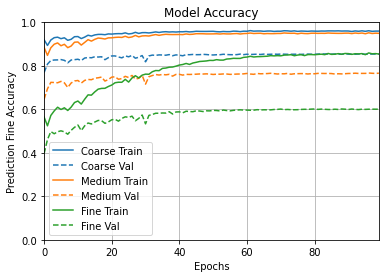

In [24]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

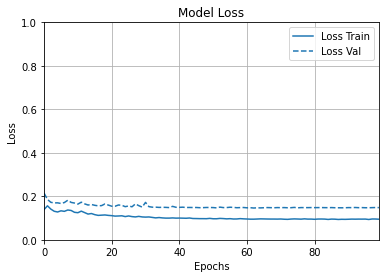

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 7s 18ms/step - loss: 0.1973 - prediction_coarse_loss: 0.1094 - prediction_medium_loss: 0.1786 - prediction_fine_loss: 0.3261 - prediction_coarse_accuracy: 0.8536 - prediction_medium_accuracy: 0.7663 - prediction_fine_accuracy: 0.6007
1. loss ==> 0.19732138514518738
2. prediction_coarse_loss ==> 0.10942485183477402
3. prediction_medium_loss ==> 0.17855192720890045
4. prediction_fine_loss ==> 0.3260577917098999
5. prediction_coarse_accuracy ==> 0.853600025177002
6. prediction_medium_accuracy ==> 0.7663000226020813
7. prediction_fine_accuracy ==> 0.6007000207901001
313/313 [==============================] - 4s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

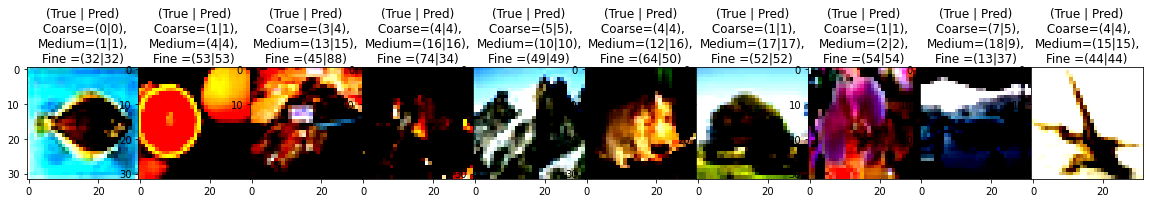

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 703   19   19   27  195   11   15   11]
 [   4 1356   30   35   46   20    2    7]
 [   7   31 1352   24   30   14   12   30]
 [  22   37   37  768  123    2    3    8]
 [  98   26   36   92 2193   10   12   33]
 [  11   30   27   10   29  858    0   35]
 [   5   11   13   12   44    2  409    4]
 [   7    0   25   12   30   28    1  897]]

  • MEDIUM LEVEL 
[[319  22   0   2   4   6   0   5  17   1   4  13  19  13   6  30  32   0
    3   4]
 [ 27 362   9   5   4   6   3   7   4   1   4   4   2   8  10  27  10   1
    2   4]
 [  0   4 435   4  21   0   2  10   1   1   4   2   1   4   0   3   1   2
    1   4]
 [  0   1   5 399  14  44   6   4   2   2   0   2   1   5   6   1   0   0
    0   8]
 [  0   2  17   6 420   9   3   6   4   1   2   2   0  11   1   5   5   3
    2   1]
 [  0   3   4  24   5 387  25   3   3   5   3   1   3   8   6   2   0   2
    6  10]
 [  1   3   0  15   1  24 420   2   1   6   1   0   2   6   4   1   0   2
    4   7]


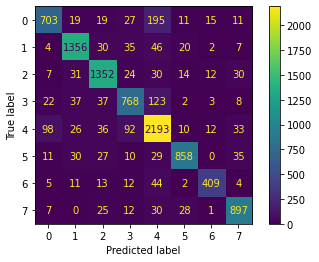

              precision    recall  f1-score   support

           0    0.82030   0.70300   0.75714      1000
           1    0.89801   0.90400   0.90100      1500
           2    0.87849   0.90133   0.88977      1500
           3    0.78367   0.76800   0.77576      1000
           4    0.81524   0.87720   0.84509      2500
           5    0.90794   0.85800   0.88226      1000
           6    0.90088   0.81800   0.85744       500
           7    0.87512   0.89700   0.88593      1000

    accuracy                        0.85360     10000
   macro avg    0.85996   0.84082   0.84930     10000
weighted avg    0.85403   0.85360   0.85287     10000


  • MEDIUM LEVEL 


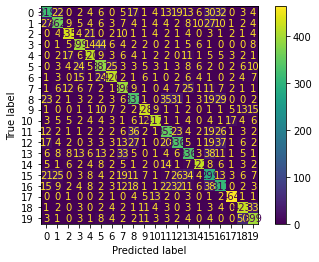

              precision    recall  f1-score   support

           0    0.70110   0.63800   0.66806       500
           1    0.78355   0.72400   0.75260       500
           2    0.85630   0.87000   0.86310       500
           3    0.80444   0.79800   0.80120       500
           4    0.81553   0.84000   0.82759       500
           5    0.71933   0.77400   0.74566       500
           6    0.84677   0.84000   0.84337       500
           7    0.74157   0.79200   0.76596       500
           8    0.68635   0.67400   0.68012       500
           9    0.85772   0.85600   0.85686       500
          10    0.89103   0.83400   0.86157       500
          11    0.71602   0.70600   0.71098       500
          12    0.68016   0.67200   0.67606       500
          13    0.68016   0.67200   0.67606       500
          14    0.88655   0.84400   0.86475       500
          15    0.56098   0.59800   0.57890       500
          16    0.62702   0.62200   0.62450       500
          17    0.91881   0

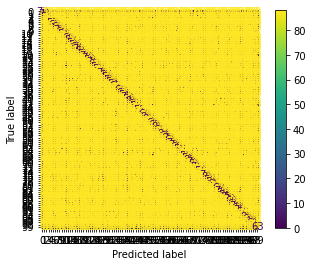

              precision    recall  f1-score   support

           0    0.87952   0.73000   0.79781       100
           1    0.85542   0.71000   0.77596       100
           2    0.39416   0.54000   0.45570       100
           3    0.37879   0.25000   0.30120       100
           4    0.42500   0.34000   0.37778       100
           5    0.61290   0.57000   0.59067       100
           6    0.76136   0.67000   0.71277       100
           7    0.58974   0.69000   0.63594       100
           8    0.74038   0.77000   0.75490       100
           9    0.90667   0.68000   0.77714       100
          10    0.33784   0.50000   0.40323       100
          11    0.39437   0.28000   0.32749       100
          12    0.67647   0.69000   0.68317       100
          13    0.46018   0.52000   0.48826       100
          14    0.50495   0.51000   0.50746       100
          15    0.56701   0.55000   0.55838       100
          16    0.73626   0.67000   0.70157       100
          17    0.87356   0

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7381966666666665 
Hierarchical Recall = 0.7537666666666666 
Hierarchical F1-Score = 0.7442444444444445 
Consistency =  0.8986 
Exact Match =  0.5851
